<a href="https://colab.research.google.com/github/alejandromanas/GoogleColab_public/blob/master/Bookings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hotel Bookings


Libraries & Functions

In [0]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import train_test_split

#Metrics

def predict_metrics(X,y,model):
        y_pred = pd.Series(model.predict(X))
        y_prob= model.predict_proba(X) 
        
        # Accuracy  
        print('Score Acc',str(metrics.accuracy_score(y,y_pred)))
        
        # AUC
        fpr, tpr, threshold = metrics.roc_curve(y, y_prob[:,1])
        roc_auc = metrics.auc(fpr, tpr)
        print('AUC = %0.2f' % roc_auc)
        
        # Logloss
        Logloss = metrics.log_loss(y, y_prob[:,1])
        print('LogLoss = %0.2f' % Logloss)
        
        return y_pred,y_prob

# Time execution mesure
def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    time_elapsed=print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

### Loading Files from Github

In [0]:
# import data from Github

X = pd.read_csv("https://raw.githubusercontent.com/alejandromanas/GoogleColab_public/master/bookings/files/X.csv", delimiter = ',')
Y = pd.read_csv("https://raw.githubusercontent.com/alejandromanas/GoogleColab_public/master/bookings/files/Y.csv", delimiter = ',')
Y_array=Y.to_numpy().ravel()

### Splitting in test & train

In [0]:
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)            

### XGBOOST

In [79]:
def XGBC_Boss(X,Y):
    
    # time 
    _start_time = time.time()
    
    tic()
    
    # Model
    
    xgbmodel=XGBClassifier()
    
    xgbmodel.get_params()
    
    params={'base_score': [0.8], # prediccion inicial
         'booster': ['gbtree'], # (gbtree, gblinear, dart)
         'colsample_bylevel': [1], # ratio de columnas en cada nivel
         'colsample_bytree': [0.8], # ratio de columnas por tree
         'gamma': [0.01],    # minimo "loss" reduccion para crear un nuevo split. Larger-> conservative
         'learning_rate': [0.01], # (eta) aportacion de cada arbol al modelo
         'max_depth': [6], # maxima profundidad en cada arbol
         'min_child_weight': [1], # minimo numero samples por hoja
         'missing': [None], # si queremos reemplazar los missings por un numero
         'n_estimators': [400], # numero de arboles
         'n_jobs': [1], # trabajos en paralelo
         'objective': ['binary:logistic'],#  Output. Tipo de función que estamos estimando
         'random_state': [15], # seed para generar los folds
         'reg_alpha': [0.01], # L1 regularitacion
         'reg_lambda': [0.01], # L2 regularitacion
         'scale_pos_weight': [1],
         'subsample': [0.9]} # ratio de muestras por cada arbol 
    
    
    # kfold = model_selection.StratifiedKFold(n_splits=3, random_state=15)
    kfold = model_selection.StratifiedShuffleSplit(n_splits=3, random_state=15)
    grid_solver = GridSearchCV(estimator = xgbmodel, # model to train
                       param_grid = params, # param_grid
                       scoring = ['accuracy'],
                       cv = kfold,
                        #n_jobs=3, 
                        n_jobs=-1,
                       refit = 'accuracy',
                       verbose = 2)
    
    model_result_xgboost = grid_solver.fit(x_train,y_train)
    
    # return predictions
    Y_pred = pd.Series(model_result_xgboost.predict(x_train))
    Y_prob= model_result_xgboost.predict_proba(x_train)
    
    # Metrics and parameters

    print('RESULTS ********** ')
   
    # print('Best score auc: '+ str(model_result_xgboost.best_score_))
    
    # print('Best parameters:',str(model_result_xgboost.best_params_))
    # print('Results :',str(model_result_xgboost.cv_results_))
    
    print('********** TRAIN ********** ')
    
    predict_metrics(x_train,y_train,model_result_xgboost)
        
    print('********** TEST ********** ')
    predict_metrics(x_test,y_test,model_result_xgboost)
    
    print('********** ALL DATA ********** ')
    Y_pd = pd.DataFrame(Y_array)
    y_pred,y_prob=predict_metrics(X,Y,model_result_xgboost)
    #predict_metrics(X,Y_pd,model_result_xgboost)

    xgbm=model_result_xgboost.best_estimator_
    
    # Plot importance PENDING
    #fig, ax = plt.subplots(figsize=(20, 15))
    fig, ax = plt.subplots(figsize=(15, 10))
    xgb.plot_importance(xgbm,ax=ax)
    
    tac() # time elapsed
      
    return Y_pred,Y_prob,model_result_xgboost

Y_pred,Y_prob,model_result_xgboost=XGBC_Boss(X,Y_array)

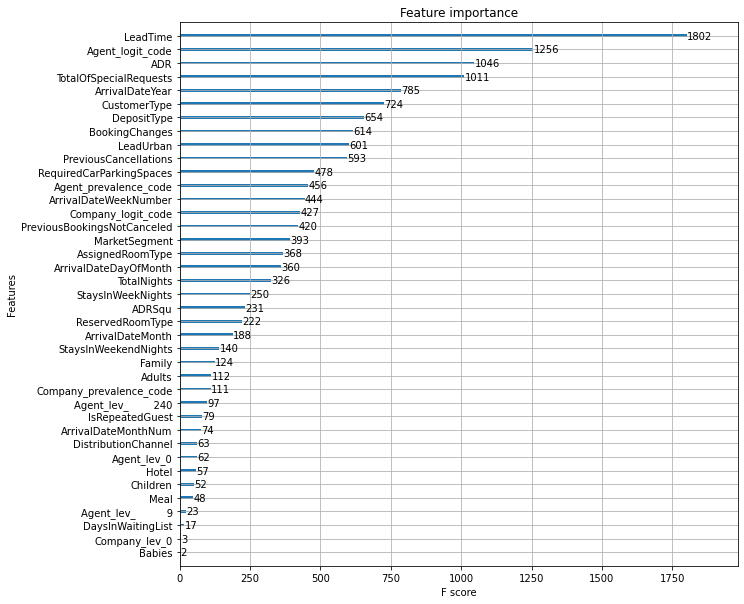

In [85]:
    fig, ax = plt.subplots(figsize=(10, 10))
    xgb.plot_importance(xgbm,ax=ax)

### lightGBM

In [0]:
def light_LGBM(X,y,param_grid):
    
  _start_time = time.time()
  tic()
     
  indexes_of_categories=[]
    
  lbl = preprocessing.LabelEncoder()
    
  for i in range(X.shape[1]):
      if X.dtypes[i]=='object':
          indexes_of_categories.append(i)
          lbl.fit(X.iloc[:,i])
          X.iloc[:,i]=lbl.transform(X.iloc[:,i])
        
  # Splitting
           
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)            
          
  # gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=train, y=y)
            
  gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X_train, y=y_train)
    
   
  # lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=2000, learning_rate=0.01, metric='auc',categorical_feature=indexes_of_categories)
    
   
  lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary',num_boost_round=2000)
    
  print('Fitting...')
    
  scoring = ['roc_auc']
  refit='roc_auc'
  # scoring = ['accuracy']
  # refit='accuracy'
   
  gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf,scoring=scoring,refit=refit)
    
  lgb_model = gsearch.fit(X=X_train, y=y_train)
    


  print('Results ********** ')
    
  print('Best score auc: '+ str(lgb_model.best_score_))
    
  print('Best parameters:',str(lgb_model.best_params_))
  print('Results :',str(lgb_model.cv_results_))
  # results=pd.DataFrame(lgb_model.cv_results_)
    
  print('********** TRAIN ********** ')
    
  predict_metrics(X_train,y_train,lgb_model)
        
  # # return predictions TRAIN
  # y_train_pred=pd.DataFrame()
  # y_train_pred = pd.Series(lgb_model.predict(X_train))
  # y_train_prob= lgb_model.predict_proba(X_train) 
    
  # print('Score Acc',str(metrics.accuracy_score(y_train,y_train_pred)))
    
  # fpr, tpr, threshold = metrics.roc_curve(y_train, y_train_prob[:,1])
  # roc_auc = metrics.auc(fpr, tpr)
  # print('AUC = %0.2f' % roc_auc)
    
  # Logloss = metrics.log_loss(y_train, y_train_prob[:,1])
  # print('LogLoss = %0.2f' % Logloss)
    
  print('********** TEST ********** ')
  predict_metrics(X_test,y_test,lgb_model)
  # # return predictions TEST
  # y_test_pred=pd.DataFrame()
  # y_test_pred = pd.Series(lgb_model.predict(X_test))
  # y_test_prob= lgb_model.predict_proba(X_test) 
    
  # print('Score Acc',str(metrics.accuracy_score(y_test,y_test_pred)))
    
  # fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_prob[:,1])
  # roc_auc = metrics.auc(fpr, tpr)
  # print('AUC = %0.2f' % roc_auc)
    
  # Logloss = metrics.log_loss(y_test, y_test_prob[:,1])
  # print('LogLoss = %0.2f' % Logloss)
    
  print('********** ALL DATA ********** ')
  y_pred,y_prob=predict_metrics(X,y,lgb_model)
  # return predictions TEST
  # y_test_pred=pd.DataFrame()
  # y_pred = pd.Series(lgb_model.predict(X))
  # y_prob= lgb_model.predict_proba(X) 
    
  # print('Score Acc',str(metrics.accuracy_score(y,y_pred)))
    
  # fpr, tpr, threshold = metrics.roc_curve(y, y_prob[:,1])
  # roc_auc = metrics.auc(fpr, tpr)
  # print('AUC = %0.2f' % roc_auc)
    
  # Logloss = metrics.log_loss(y, y_prob[:,1])
  # print('LogLoss = %0.2f' % Logloss)
   
  # Plot importance PENDING
  # fig, ax = plt.subplots(figsize=(20, 15))
    
  # lgb.plot_importance(lgb_estimator,ax=ax)
  # lgb.plot_importance(gsearch.Booster,ax=ax)
  # lgb.plot_importance(lgb_model.Booster_Booster,ax=ax)
  # lgb.plot_importance(lgb_model,ax=ax)
    
  # plot_tree(lgb_model._Booster)
    
    
  # lgb_model.plot_importance()
  # # fig = plot_imp.figure
  # # fig.set_size_inches(5, 10)
  # plt.savefig('lightLGBM.png')
        
   
  # time
  tac()
    
  return y_pred,y_prob,

param_grid = {
'num_leaves': [31],
  # 'num_boost_round': [2000],
  'learning_rate':[0.1],
  # 'reg_alpha': [0.1],
  'min_data_in_leaf': [30],
  'lambda_l1': [0],
  'lambda_l2': [0],
  'min_data_in_leaf':[100],
  'max_depth': [3],
  # 'num_boost_round': [2000]
  # n_estimators=100,
  # subsample=1.0, 
  }    

y_pred,y_prob = light_LGBM(X,y,param_grid)